# **EMF-Glucose Analysis and Visualization Platform**

## What it does:
This Jupyter notebook provides a comprehensive framework for investigating the relationship between electromagnetic field (EMF) biomarkers and continuous glucose monitoring (CGM) data. It's designed for biomedical research that explores potential correlations between EMF signals recorded from the human body and glucose level fluctuations.

### **1. Synchronized Multi-Modal Visualization**
- **Time-domain correlation analysis**: Creates simultaneous plots of EMF signals and glucose trajectories with clinical event markers overlaid
- **Clinical context integration**: Incorporates insulin injection and nutritional intake events (like Ensure sugar supplements) for comprehensive physiological interpretation
- **Adaptive time windowing**: Provides flexible analysis windows with configurable duration and offset parameters to focus on specific time periods

### **2. Advanced Spectral Analysis Suite**
- **Power Spectral Density (PSD) analysis**: Uses Welch's method with optimized windowing for robust frequency domain characterization of EMF signals

### **3. Time-Frequency Analysis**
- **High-resolution spectrograms**: Implements Short-Time Fourier Transform (STFT) with customizable time-frequency resolution
- **Temporal evolution tracking**: Analyzes dynamic frequency content changes aligned with glucose fluctuations
- **Clinical correlation mapping**: Creates time-aligned spectrograms to identify EMF changes during glycemic events

### **4. Technical Implementation**
- Processes downsampled EMF signals (25 Hz) stored in Parquet format for efficient data handling
- Loads CGM data from Excel files with synchronized timestamps
- Applies sensor-specific calibration factors and saturation limits (±250 nT)
- Implements noise filtering and artifact removal
- Generates publication-quality visualizations with proper clinical annotations
- Saves results in organized directory structures for further analysis

The code is specifically designed for analyzing data from subjects with Type 1 Diabetes Mellitus (T1DM) during glucose clamp studies, as well as normal volunteers, making it a specialized tool for diabetes-related EMF biomarker research.

In [55]:
# General imports:

# Disable warnings:
import warnings

warnings.filterwarnings('ignore')

# Essential imports
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from pathlib import Path

from scipy.signal import spectrogram
import gc # For garbage collection

# Plotting enhancements
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['image.cmap'] = 'turbo'  # Set default colormap to turbo for all images
plt.style.use('seaborn-v0_8-whitegrid')

#### Base variables and constants:

In [56]:
# Key Settings:

# Physical constants and sensors specifications:
SENSITIVITY = 50  # mV/nT
MAGNETIC_NOISE = 3  # pT/√Hz @ 1 Hz
MAX_AC_LINEARITY = 250  # nT (+/- 250 nT) - Equivalent to 21.78 V
MAX_DC_LINEARITY = 60  # nT (+/- 60 nT)
VOLTAGE_LIMIT = 15 # V (+/-15V)
CONVERSION_FACTOR = 20  # nT per 1V
SAMPLING_FREQUENCY = 5000  # Hz - expected from the experimental data (we downsampling to 25Hz)
SENSOR_SATURATION = 250  # nT - saturation threshold for the sensor

# Subjects and their types (in this file it is for general information only)
Subject = {"Normal": "Normal Subjects","Clamp": "T1DM Clamp Subjects", "Additional": "Additional Subjects"}

# Path and directories
base_dir = Path("../../../Data")

# Output directory for saving results
output_dir = base_dir / "ProcessedData"
os.makedirs(output_dir, exist_ok=True)

# Directory for saving processed/downsampled signal files (parquet format)
signals_dir = output_dir / "Signal_Files"
os.makedirs(signals_dir, exist_ok=True)

# Labels directory
labels_dir = base_dir / "RawData"
labels_filename = "FilteredLabels.xlsx"

# Patients data file
patients_file = "patients.json"


#### Load patient data and filter by subject type:

In [57]:
# selected_subject = "Insulin Clamp #10"  # Subject for visualization
# selected_subject = "Normal #10"
# selected_subject = "Additional #3"
selected_subject = "volunteer_part4"

target_fs = 25 # Hz - Downsampled signal frequency (in this case, downsampled)

time_window_hours = None  # Set to None to use all available time, or specify hours (e.g., 4)
start_offset_hours = 0  # Offset for visualization
f_min = 0.1  # Minimum frequency for spectrogram (0.1 Hz)
f_max = 12.5  # Maximum frequency for spectrogram (Nyquist limit for 25Hz sampling)


#### Function to load downsampled EMF signal from parquet file

In [58]:
def load_downsampled_signal(subject_name, signals_dir):
    """
    Load downsampled EMF signal data from parquet file.

    Parameters:
    - subject_name: name of the subject (e.g., "Insulin_Clamp #1")
    - signals_dir: directory containing the parquet signal files

    Returns:
    - df_signal: polars DataFrame with loaded signal data
    """
    # Create filename based on subject name
    subject_safe_name = subject_name.replace(" ", "_").replace("#", "")
    filename = f"{subject_safe_name}_downsampled_25hz.parquet"
    filepath = signals_dir / filename

    try:
        if filepath.exists():
            df_signal = pl.read_parquet(filepath)
            print(f"Successfully loaded signal data from {filename}")
            print(f"Signal data shape: {df_signal.shape}")
            print(f"Available channels: {[col for col in df_signal.columns if col.lower() != 'time']}")
            return df_signal
        else:
            print(f"File not found: {filepath}")
            return None
    except Exception as e:
        print(f"Error loading parquet file: {e}")
        return None


#### Function to load CGM data

In [59]:
def load_cgm_data(subject_name, labels_dir, labels_filename):
    """
    Load CGM (glucose) data from Excel file.

    Parameters:
    - subject_name: name of the subject
    - labels_dir: directory containing the labels file
    - labels_filename: name of the Excel file

    Returns:
    - df_cgm: polars DataFrame with CGM data
    """
    labels_path = labels_dir / labels_filename

    try:
        # Read Excel file for the specific subject
        df_cgm = pl.read_excel(
            labels_path,
            sheet_name=subject_name,
            columns=[0, 1, 2, 3],  # time, Glucose, Events, Remarks
            schema_overrides={
                "time": pl.Datetime,
                "Glucose": pl.Float64,
                "Events": pl.Utf8,
                "Remarks": pl.Utf8
            }
        )

        # Keep only the first 4 columns
        if len(df_cgm.columns) >= 4:
            df_cgm = df_cgm.select(df_cgm.columns[:4])

        print(f"Successfully loaded CGM data for {subject_name}")
        print(f"CGM data shape: {df_cgm.shape}")
        return df_cgm

    except Exception as e:
        print(f"Error loading CGM data: {e}")
        return None


#### Main execution: Load data and create visualizations

In [60]:
# Load the downsampled EMF signal data
print(f"Loading EMF signal data for {selected_subject}...")
df_signal = load_downsampled_signal(selected_subject, signals_dir)

# Load the CGM data
print(f"\nLoading CGM data for {selected_subject}...")
df_cgm = load_cgm_data(selected_subject, labels_dir, labels_filename)

# Display data information
if df_signal is not None:
    print(f"\nSignal data loaded successfully!")
    print(f"Time range: {df_signal['Time'].min()} to {df_signal['Time'].max()}")
    print(f"Duration: {(df_signal['Time'].max() - df_signal['Time'].min()).total_seconds()/3600:.2f} hours")
    print(f"Available channels: {[col for col in df_signal.columns if col.lower() != 'time']}")

if df_cgm is not None:
    print(f"\nCGM data loaded successfully!")
    print(f"Number of glucose measurements: {len(df_cgm.filter(pl.col('Glucose').is_not_null()))}")
    print(f"Number of events: {len(df_cgm.filter(pl.col('Events').is_not_null()))}")


Loading EMF signal data for volunteer_part4...
Successfully loaded signal data from volunteer_part4_downsampled_25hz.parquet
Signal data shape: (716200, 3)
Available channels: ['Hand1', 'Hand2']

Loading CGM data for volunteer_part4...
Successfully loaded CGM data for volunteer_part4
CGM data shape: (242, 4)

Signal data loaded successfully!
Time range: 2021-12-15 21:29:29.463300 to 2021-12-16 07:23:24.923300
Duration: 9.90 hours
Available channels: ['Hand1', 'Hand2']

CGM data loaded successfully!
Number of glucose measurements: 242
Number of events: 0


#### Signal Processing and Analysis Functions

In [61]:
def visualize_combined_spectrogram_emf_cgm(df_signal, df_cgm, channel_name,
                                          time_window_hours=None, start_offset_hours=0,
                                          figsize=(15, 12), fs=25,
                                          spectrogram_params=None):
    """
    Create a combined visualization with:
    - Upper chart: Spectrogram (without X-axis labels)
    - Lower chart: EMF signal with CGM data overlay (with X-axis labels using 30-minute intervals)
    - Shared time axis between both charts

    Parameters:
    - df_signal: polars DataFrame with signal data
    - df_cgm: polars DataFrame with CGM data
    - channel_name: name of the channel to visualize
    - time_window_hours: duration in hours to display (None for complete EMF signal duration)
    - start_offset_hours: hours to offset from start
    - figsize: figure size tuple
    - fs: sampling frequency (Hz)
    - spectrogram_params: dict with spectrogram parameters (nperseg, noverlap, f_min, f_max)

    Returns:
    - fig: matplotlib figure object
    - (ax_spec, ax_emf): tuple of axis objects (spectrogram, EMF+CGM)
    """

    # Default spectrogram parameters
    if spectrogram_params is None:
        spectrogram_params = {
            'nperseg': 1024,
            'noverlap': None,
            'f_min': 0.1,
            'f_max': 25.0
        }

    # Find time column in signal data
    time_col = None
    for col in df_signal.columns:
        if col.lower() == 'time':
            time_col = col
            break

    if time_col is None:
        print("No time column found in signal data")
        return None, None

    # Check if channel exists
    if channel_name not in df_signal.columns:
        print(f"Channel '{channel_name}' not found in signal data")
        print(f"Available channels: {[col for col in df_signal.columns if col.lower() != 'time']}")
        return None, None

    # Convert to pandas for easier plotting
    df_signal_pd = df_signal.to_pandas()

    # Filter out rows where EMF signal is NaN or missing for this channel
    valid_signal_mask = df_signal_pd[channel_name].notna()
    df_signal_pd = df_signal_pd[valid_signal_mask]

    if len(df_signal_pd) == 0:
        print(f"No valid EMF signal data found for channel {channel_name}")
        return None, None

    # Apply time windowing if specified (based on EMF signal availability)
    if time_window_hours is not None or start_offset_hours > 0:
        # Use EMF signal time range as reference
        emf_start_time = df_signal_pd[time_col].min()
        emf_end_time = df_signal_pd[time_col].max()

        start_time = emf_start_time + pd.Timedelta(hours=start_offset_hours)

        if time_window_hours is not None:
            end_time = start_time + pd.Timedelta(hours=time_window_hours)
            # Ensure we don't go beyond available EMF data
            end_time = min(end_time, emf_end_time)
        else:
            # Use all available EMF data from start_time
            end_time = emf_end_time

        mask = (df_signal_pd[time_col] >= start_time) & (df_signal_pd[time_col] <= end_time)
        df_signal_pd = df_signal_pd[mask]

        if time_window_hours is not None:
            print(f"Displaying EMF data from {start_time} for {time_window_hours} hours (until {end_time})")
        else:
            print(f"Displaying complete EMF data from {start_time} to {end_time}")
    else:
        print(f"Displaying complete EMF signal duration: {df_signal_pd[time_col].min()} to {df_signal_pd[time_col].max()}")

    # Create subplot layout with shared X-axis and make upper subplot taller
    fig, (ax_spec, ax_emf) = plt.subplots(2, 1, figsize=figsize, sharex=True,
                                          gridspec_kw={'height_ratios': [1.5, 1], 'hspace': 0.1})

    # ======================
    # UPPER PLOT: SPECTROGRAM
    # ======================

    # Prepare signal data for spectrogram
    signal_data = df_signal_pd[channel_name].values
    time_data = df_signal_pd[time_col].to_numpy()
    time_points = df_signal_pd[time_col].values

    # Get total length of signal
    signal_length = len(signal_data)

    # Calculate appropriate nperseg - use a much smaller value for long signals
    if signal_length > 20000:  # Very long signal (>10 minutes at 25Hz)
        nperseg = 256  # Use small window for better time resolution
    else:
        nperseg = min(1024, signal_length // 4)  # Default to 1024 but ensure it's appropriate for signal length

    # Ensure nperseg is even
    if nperseg % 2 == 1:
        nperseg -= 1

    # Set noverlap - for better time resolution with small nperseg
    noverlap = int(nperseg * 0.75)  # 75% overlap

    print(f"Using nperseg={nperseg}, noverlap={noverlap} for spectrogram calculation")
    print(f"Signal length: {signal_length} samples")

    # Calculate spectrogram
    freqs, times_spec, Sxx = spectrogram(signal_data, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # Create absolute timestamps for spectrogram
    # This is the critical part for alignment
    step_size = nperseg - noverlap  # How many samples we advance each step

    # Create a mapping between spectrogram time indices and signal time indices
    # Each time in times_spec corresponds to the middle of a segment
    spec_indices = []
    for i in range(len(times_spec)):
        # Calculate the center index of this segment in the original signal
        center_idx = min(int(i * step_size + nperseg/2), signal_length - 1)
        spec_indices.append(center_idx)

    # Map those indices to actual timestamps
    times_spec_abs = time_data[spec_indices]

    # Filter frequency range
    f_min = spectrogram_params['f_min']
    f_max = min(spectrogram_params['f_max'], fs/2)  # Ensure f_max doesn't exceed Nyquist
    freq_mask = (freqs >= f_min) & (freqs <= f_max)
    freqs = freqs[freq_mask]
    Sxx = Sxx[freq_mask, :]

    # Plot spectrogram with exact timestamp alignment
    im = ax_spec.pcolormesh(times_spec_abs, freqs, 10 * np.log10(Sxx),
                           shading='gouraud', cmap='turbo')

    ax_spec.set_ylabel('Frequency (Hz)', fontsize=12)
    ax_spec.set_title(f'{channel_name} - Combined Spectrogram and EMF Signal with CGM Data',
                     fontsize=14, fontweight='bold')

    # Add colorbar for spectrogram - positioned outside right of upper subplot only
    # Get position of spectrogram axes for alignment
    pos_spec = ax_spec.get_position()
    cbar_ax = fig.add_axes([pos_spec.x1 + 0.05, pos_spec.y0, 0.02, pos_spec.height])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Power Spectral Density (dB)', fontsize=12)

    # Create secondary y-axis for glucose on upper subplot
    ax_spec_twin = ax_spec.twinx()

    ax_spec_twin.set_zorder(ax_spec.get_zorder() + 1)
    ax_spec_twin.patch.set_alpha(0)

    # Remove X-axis labels from upper plot (as required)
    ax_spec.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # ======================
    # LOWER PLOT: EMF + CGM
    # ======================

    # Plot raw EMF signal (gray background)
    ax_emf.plot(df_signal_pd[time_col], df_signal_pd[channel_name],
               color='gray', linewidth=1, alpha=0.5, label='Raw EMF')

    # Filter EMF signal <0.1 Hz
    from scipy.signal import butter, filtfilt
    # Design lowpass filter with cutoff at 0.1 Hz
    nyquist = fs / 2
    cutoff = 0.1
    order = 4
    b, a = butter(order, cutoff / nyquist, btype='low')
    filtered_signal = filtfilt(b, a, df_signal_pd[channel_name].values)

    # Plot filtered EMF signal (blue, prominent)
    ax_emf.plot(df_signal_pd[time_col], filtered_signal,
               color='blue', linewidth=1, alpha=0.8, label='Filtered <0.1Hz EMF')

    ax_emf.set_ylabel('EMF Signal (nT)', color='blue', fontsize=12)
    ax_emf.tick_params(axis='y', labelcolor='blue')
    ax_emf.grid(True, alpha=0.3)

    # Add sensor saturation limits
    ax_emf.axhline(y=SENSOR_SATURATION, color='red', linestyle='--', alpha=0.5)
    ax_emf.axhline(y=-SENSOR_SATURATION, color='red', linestyle='--', alpha=0.5)

    # Create secondary y-axis for glucose if CGM data is available
    if df_cgm is not None and len(df_cgm) > 0:
        ax_emf_twin = ax_emf.twinx()

        ax_emf.set_zorder(2)
        ax_emf_twin.set_zorder(1)
        ax_emf.patch.set_alpha(0)

        # Convert CGM data to pandas and filter to same time range as EMF signal
        df_cgm_pd = df_cgm.to_pandas()

        # Filter CGM data to match the EMF signal time range being displayed
        emf_start_displayed = df_signal_pd[time_col].min()
        emf_end_displayed = df_signal_pd[time_col].max()
        cgm_mask = (df_cgm_pd['time'] >= emf_start_displayed) & (df_cgm_pd['time'] <= emf_end_displayed)
        df_cgm_pd = df_cgm_pd[cgm_mask]

        # Plot glucose data on both upper and lower plots
        if len(df_cgm_pd) > 0:
            # Remove NaN glucose values
            df_cgm_clean = df_cgm_pd.dropna(subset=['Glucose'])

            if len(df_cgm_clean) > 0:
                # Plot glucose on upper subplot (spectrogram)
                ax_spec_twin.plot(df_cgm_clean['time'], df_cgm_clean['Glucose'],
                               'go-', markersize=4, linewidth=1.5, alpha=0.7)
                ax_spec_twin.set_ylabel('Glucose (mg/dL)', color='green', fontsize=12)
                ax_spec_twin.tick_params(axis='y', labelcolor='green')

                # Plot glucose on lower subplot (EMF)
                ax_emf_twin.plot(df_cgm_clean['time'], df_cgm_clean['Glucose'],
                               'go-', markersize=5, linewidth=2, alpha=0.8)
                ax_emf_twin.set_ylabel('Glucose (mg/dL)', color='green', fontsize=12)
                ax_emf_twin.tick_params(axis='y', labelcolor='green')

                # Add glucose threshold lines to both plots
                for ax_twin in [ax_spec_twin, ax_emf_twin]:
                    ax_twin.axhline(y=70, color='blue', linestyle=':', alpha=0.7)
                    ax_twin.axhline(y=180, color='red', linestyle=':', alpha=0.7)

                # Add event markers (insulin and ensure as vertical lines) with labels
                events_df = df_cgm_pd.dropna(subset=['Events'])
                if len(events_df) > 0:
                    # Get the y-axis limits for positioning labels
                    y_min, y_max = ax_emf.get_ylim()
                    label_y_position = y_max * 0.95  # Position labels at 95% of the max y value

                    # Insulin events
                    insulin_events = events_df[events_df['Events'] == 'Insulin Injection']
                    if len(insulin_events) > 0:
                        for t in insulin_events['time']:
                            # Draw vertical line
                            ax_emf.axvline(x=t, color='blue', linestyle='--', alpha=1, linewidth=1)
                            ax_spec.axvline(x=t, color='blue', linestyle='--', alpha=1, linewidth=1)

                            # Add label above the line in lower chart
                            legend_insulin = ax_emf.text(t, label_y_position, 'Insulin',
                                       rotation=90, ha='right', va='top',
                                       color='blue', fontsize=8, fontweight='bold',
                                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=1, edgecolor='blue'))
                            # Ensure text is on top of lines
                            legend_insulin.set_zorder(10000)

                    # Ensure (sugar) events
                    ensure_events = events_df[events_df['Events'] == 'Ensure']
                    if len(ensure_events) > 0:
                        for t in ensure_events['time']:
                            # Draw vertical line
                            ax_emf.axvline(x=t, color='black', linestyle='--', alpha=1, linewidth=1)
                            ax_spec.axvline(x=t, color='black', linestyle='--', alpha=1, linewidth=1)

                            # Add label above the line in lower chart
                            legend_ensure = ax_emf.text(t, label_y_position, 'Ensure',
                                       rotation=90, ha='right', va='top',
                                       color='black', fontsize=8, fontweight='bold',
                                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=1, edgecolor='black'))
                            # Ensure text is on top of lines
                            legend_ensure.set_zorder(10000)

    # Format time axis - Use 30-minute intervals instead of 1-hour
    ax_emf.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax_emf.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
    plt.setp(ax_emf.xaxis.get_majorticklabels(), rotation=45)

    # Set X-axis label only on the lower chart
    ax_emf.set_xlabel('Time', fontsize=10)

    plt.tight_layout()

    # Legend only for EMF signals (Raw and Filtered) - positioned above the lower chart
    lines1, labels1 = ax_emf.get_legend_handles_labels()
    legend = ax_emf.legend(lines1, labels1, loc='lower right', bbox_to_anchor=(1, 0),
                           frameon=True, fancybox=True, shadow=True, framealpha=1, ncol=2)
    # Make legend draw above everything
    legend.set_zorder(10000)
    for lh in legend.legend_handles:  # correct attribute name
        lh.set_zorder(10001)
    if legend.get_frame() is not None:
        legend.get_frame().set_zorder(10002)

    # Force both plots to have exactly the same x-axis limits (add these lines here)
    ax_spec.set_xlim(time_points[0], time_points[-1])
    ax_emf.set_xlim(time_points[0], time_points[-1])

    # Force a redraw
    plt.draw()

    return fig, (ax_spec, ax_emf)

Starting power spectrum analysis using downsampled signal data
Data shape: (716200, 3)
Available columns: ['Time', 'Hand1', 'Hand2']

Creating combined spectrogram and EMF+CGM visualizations for all channels...
Available channels: ['Hand1', 'Hand2']
Combined charts will be saved to: ..\..\..\Data\ProcessedData\EMF_Visualization

Creating combined visualization for channel: Hand1
Displaying complete EMF signal duration: 2021-12-15 21:29:29.463300 to 2021-12-16 07:23:24.923300
Using nperseg=256, noverlap=192 for spectrogram calculation
Signal length: 712962 samples


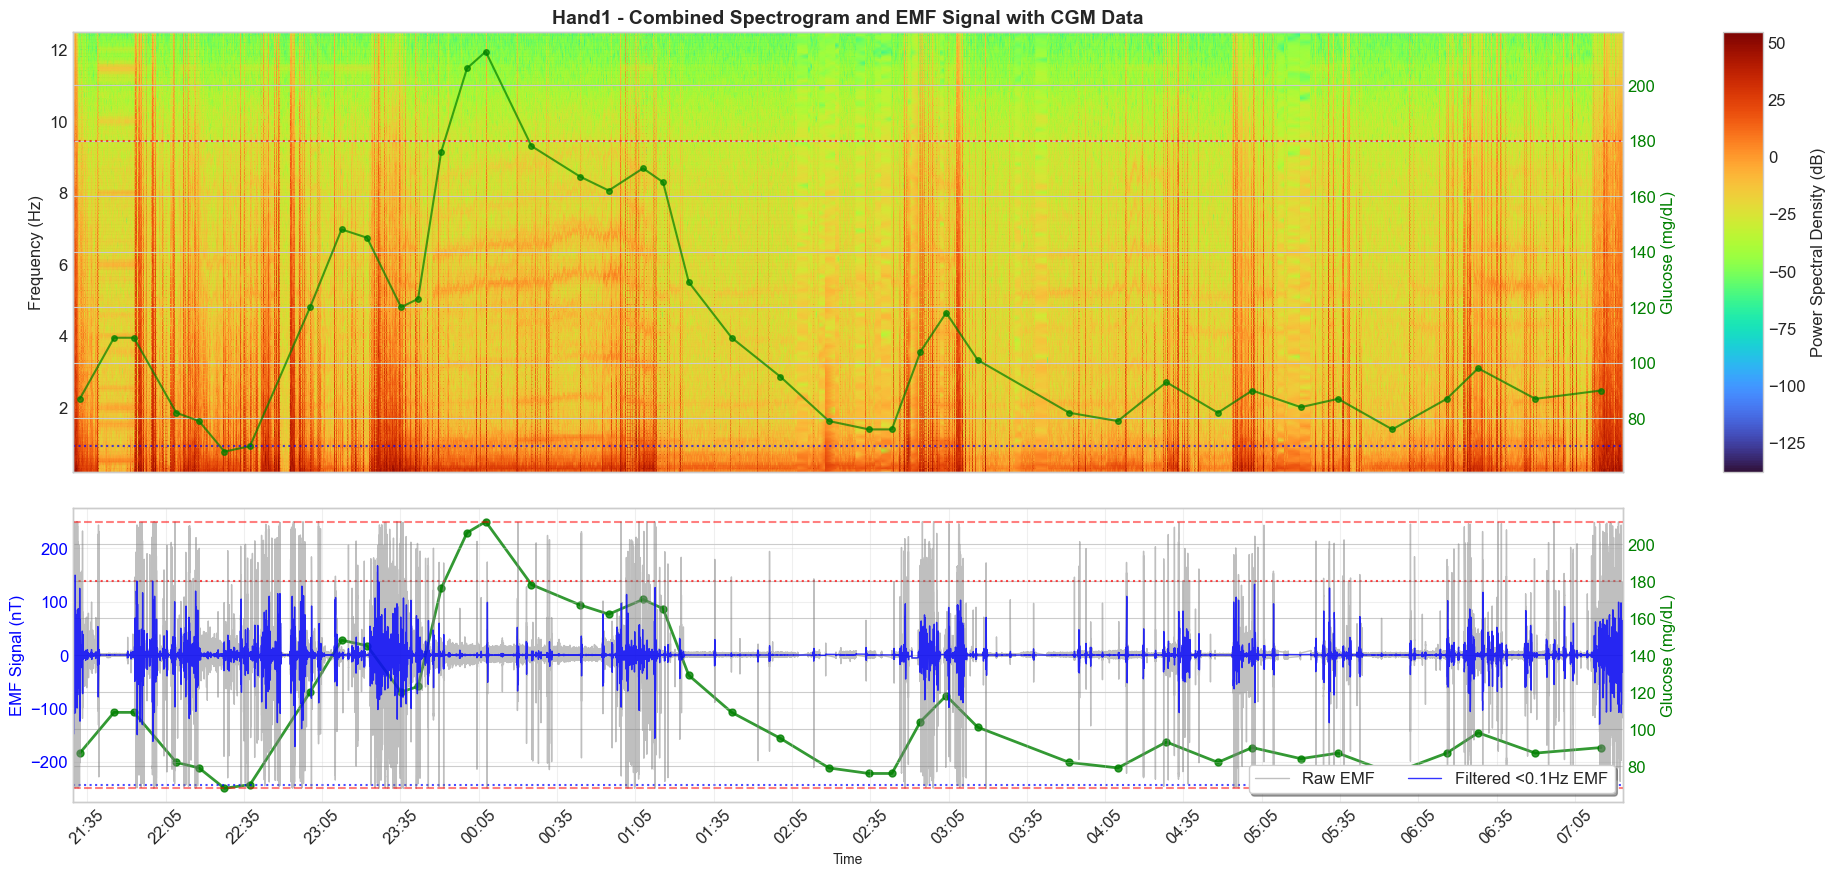

Combined visualization saved to: ..\..\..\Data\ProcessedData\EMF_Visualization\volunteer_part4_Hand1_combined_spectrogram_emf_cgm.png

Creating combined visualization for channel: Hand2
Displaying complete EMF signal duration: 2021-12-15 21:29:29.463300 to 2021-12-16 07:23:24.923300
Using nperseg=256, noverlap=192 for spectrogram calculation
Signal length: 716175 samples


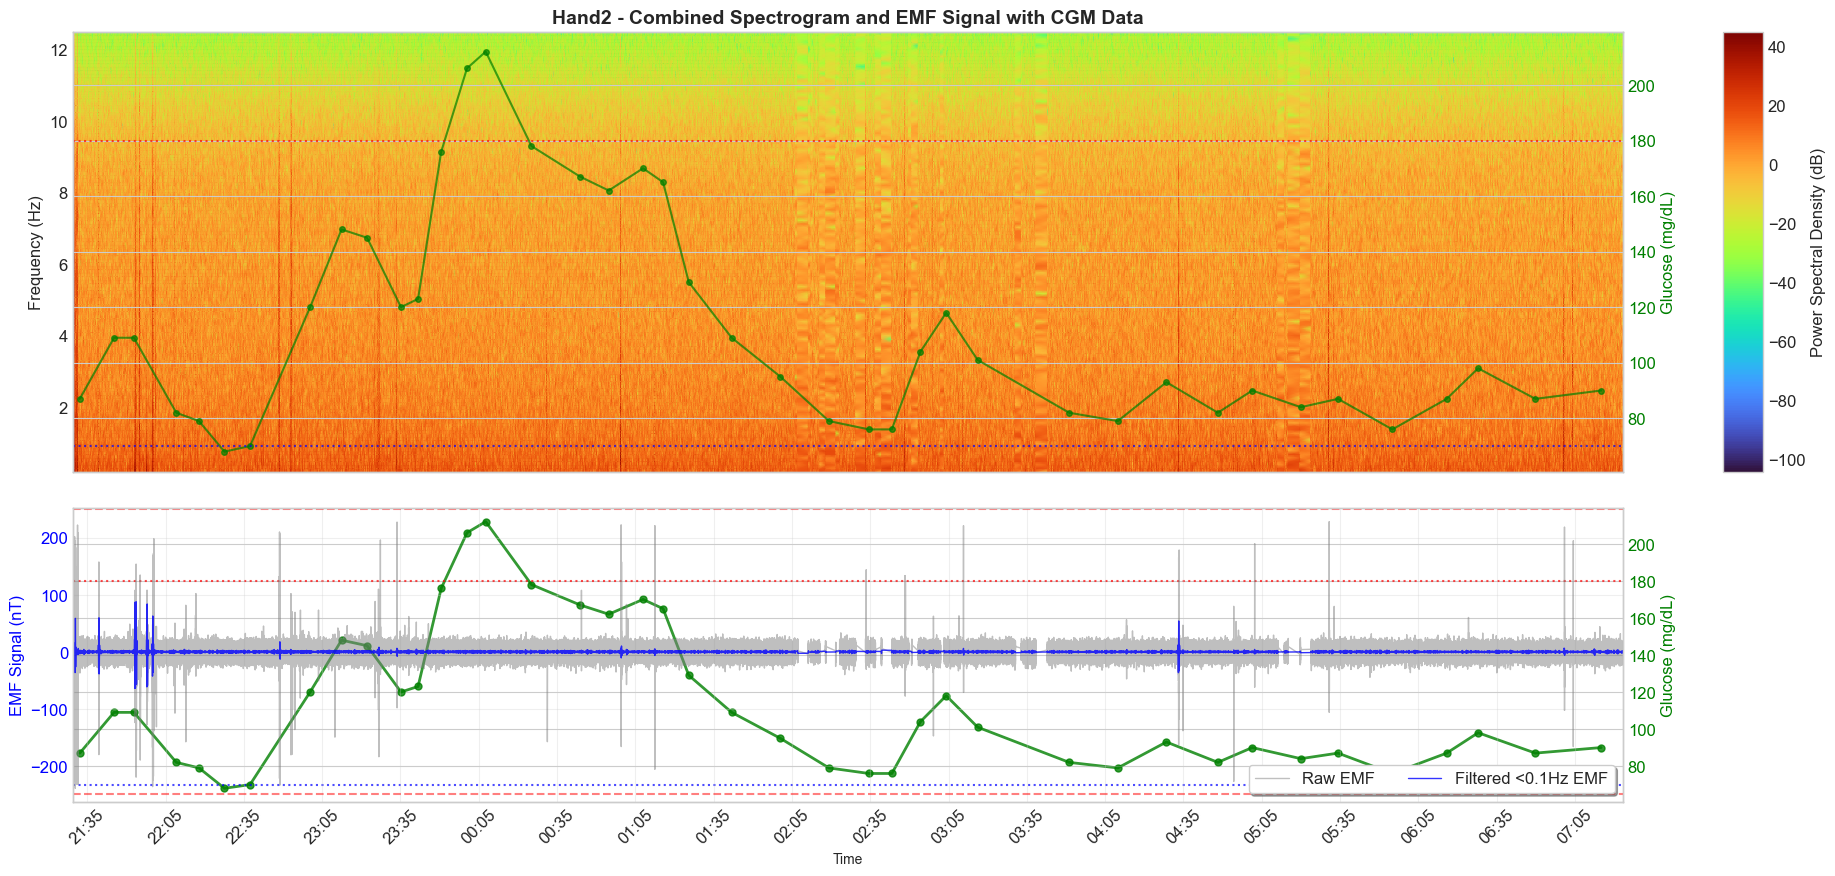

Combined visualization saved to: ..\..\..\Data\ProcessedData\EMF_Visualization\volunteer_part4_Hand2_combined_spectrogram_emf_cgm.png


In [62]:
if df_signal is not None:

    print(f"Starting power spectrum analysis using downsampled signal data")
    print(f"Data shape: {df_signal.shape}")
    print(f"Available columns: {df_signal.columns}")
    print(f"\nCreating combined spectrogram and EMF+CGM visualizations for all channels...")

    spectrogram_params = {
            'nperseg': 1024,
            'noverlap': None,
            'f_min': f_min,
            'f_max': f_max
        }

    # Get available signal channels (exclude time column)
    time_col = 'Time' if 'Time' in df_signal.columns else 'time'
    available_channels = [col for col in df_signal.columns if col != time_col]

    print(f"Available channels: {available_channels}")

    # Create output directory for analysis
    visualization_output_dir = output_dir / "EMF_Visualization"
    os.makedirs(visualization_output_dir, exist_ok=True)
    print(f"Combined charts will be saved to: {visualization_output_dir}")

    for channel in available_channels:
        print(f"\nCreating combined visualization for channel: {channel}")

        # Create combined visualization with spectrogram and EMF+CGM
        fig, (ax_spec, ax_emf) = visualize_combined_spectrogram_emf_cgm(
            df_signal,
            df_cgm,
            channel,
            figsize=(20,10),
            time_window_hours=time_window_hours,
            start_offset_hours=start_offset_hours,
            fs=target_fs,
            spectrogram_params=spectrogram_params
        )

        if fig is not None:
            plt.show()

            # Save the figure to CombinedAnalysis folder
            save_path = visualization_output_dir / f"{selected_subject.replace(' ', '_').replace('#', '')}_{channel}_combined_spectrogram_emf_cgm.png"
            fig.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Combined visualization saved to: {save_path}")

            # Close the figure to free memory
            plt.close(fig)
        else:
            print(f"Failed to create combined visualization for {channel}")
else:
    print("No signal data available for combined visualization")

In [64]:
gc.collect()  # Run garbage collection to free memory


0